In [ ]:
#| default_exp data

In [ ]:
#| export
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from fastcore.all import *
from fastai.vision.all import *
from andi_datasets.datasets_theory import datasets_theory
from andi_datasets.utils_trajectories import normalize
from collections.abc import Iterable, Callable

# Data info

We provide a set of variables with default information about the nature of the data and the default path to save it.

In [ ]:
#| exports
ROOT = Path(os.path.dirname(os.path.abspath('../')))
DATA_PATH = ROOT/"data/"
DATA_PATH.mkdir(exist_ok=True, parents=True)
FIG_PATH = DATA_PATH/"figures"
FIG_PATH.mkdir(exist_ok=True, parents=True)
MODEL_PATH = ROOT/"models"
MODEL_PATH.mkdir(exist_ok=True, parents=True)

MODEL_DATA = {
    0: {'name': 'attm', 'exps': (0.05, 1.)},
    1: {'name': 'ctrw', 'exps': (0.05, 1.)},
    2: {'name': 'fbm',  'exps': (0.05, 1.95)},
    3: {'name': 'lw',   'exps': (1.05, 2.)},
    4: {'name': 'sbm',  'exps': (0.05, 2.)}
    }
              
DEFAULT_TOKEN = -1

By default, we keep the root of the repository in `ROOT`, from which we define `DATA_PATH=ROOT/'data'` and `MODEL_PATH=ROOT/'models'`, subsequently, we define `FIG_PATH=DATA_PATH/'figures'`. We use these as default paths to save and load the data, the trained models and the output figures.

Then, `MODEL_DATA` is a dictionary containing the information about the different anomalous diffusion models that we consider.
And `DEFAULT_TOKEN=-1` is the default value for the beginning of sequence token.

# Data generation

To train our models, we make extensive use of simulated trajectories. The goal is to simulate realistic conditions in experiments to help our models generalize well in experimental applications.

We follow two main approaches to simulate our data depending on whether we're working with anomalous diffusion or Brownian motion (normal diffusion).
 
However, the main framework is common for both. To generate trajectories with changes in diffusive behaviour, we simulate as many full trajectories as different segments we wish to have. Then, we take a sample segment of each and combine them together to obtain the resulting heterogeneous trajectory.

In [ ]:
#| export
def combine_trajectories(datasets, dim, margin=10, random_lengths=False):
    """Combine the trajectories in `datasets` to create heterogeneous
    trajectories by assigning random changepoints in between."""
    n_change = len(datasets) - 1
    min_t = (n_change + 1)*margin 
    n_trajs, max_t = datasets[0].shape[0], datasets[0][0, 2:].reshape(dim, -1).shape[-1]
    if max_t < min_t: 
        raise ValueError("Trajectory length must be, at least, (change points + 1) times" +
                         f"the margin. Got length {max_t} for margin {margin}" +
                         f"and {n_change} change points.")
    lengths = (np.random.randint(min_t, max_t+1, n_trajs) if random_lengths 
               else np.ones(n_trajs, dtype=int)*max_t)
    change_points = _get_change_points(n_change, lengths, margin)
    datasets = _permute_datasets(datasets)
    trajectories, labels = [], []
    for n in range(n_trajs):
        trajs = [datasets[c][n, 2:] for c in range(n_change+1)]
        trajectories.append(_merge_trajectories(trajs, change_points[n], dim, max_t=lengths[n]))
        labels.append(np.concatenate([datasets[c][n, :2] for c in range(n_change+1)]))
    return trajectories, labels, change_points
                
def _add_permutation_sample(repeated, datasets, idx):
    "Checks conditions in order add an additional sample from which to perform permutations"
    check_length = len(repeated) <= 2
    check_ds = [len(np.unique(ds[i[repeated], 0]))==1 or len(np.unique(ds[i[repeated], 1]))==1 
                for ds,i in zip(datasets, idx)]
    return check_length or np.any(check_ds)
      
def _merge_trajectories(trajs, change_points, dim, max_t=None):
    "Merges trajectories `trajs` with `change_points` accounting for dimension."
    trajs = [traj.reshape(dim, -1) for traj in trajs]
    cps = [0] + list(change_points) + [max_t]
    slices = [slice(cps[c], cps[c+1]) for c in range(len(cps)-1)]
    offsets = [np.zeros((dim, 1))] + [np.expand_dims(t1[:, c] - t2[:, c], -1) 
                                      for t1, t2, c in zip(trajs[:-1], trajs[1:], change_points)]
    offsets = np.cumsum(offsets, axis=0)
    return np.concatenate([traj[:, s]+o for traj, s, o in zip(trajs, slices, offsets)], axis=1)
    
def _get_change_points(n_change, lengths, margin):
    n_trajs = lengths.shape[0]
    change_points = np.zeros((n_trajs, n_change), dtype=int)
    if n_change == 1:
        change_points[:, 0] = np.random.randint(margin, lengths-margin, n_trajs)
        return change_points
    
    change_points[:, 0] = np.random.triangular(margin, margin, lengths-n_change*margin, n_trajs).astype(int)
    for n in range(n_change-1):
        min_t, max_t = change_points[:, n]+margin, lengths-(n_change-n-1)*margin
        if n < n_change - 2:
            change_points[:, n+1] = np.random.triangular(min_t, min_t, max_t, n_trajs).astype(int)
        else: 
            change_points[:, n+1] = np.random.randint(min_t, max_t, n_trajs)
    # Workaround to account for imbalances in sampling. Works decently until n_change=4
    mask = np.random.randint(0, 2, n_trajs, dtype=bool)
#     change_points[mask] = np.sort(np.abs(change_points[mask] - lengths[mask, None]))
    return change_points

def _permute_datasets(datasets, max_iter=1000):
    "Permutes datasets to prevent having the same labels in contiguous segments."
    n_traj = datasets[0].shape[0]
    idx = [np.random.permutation(n_traj) for ds in datasets]
    for d in range(1, len(datasets)):
        i = slice(d-1, d)
        diff = np.abs(datasets[d-1][idx[d-1], :2] - datasets[d][idx[d], :2]).sum(1)
        repeated = np.argwhere(diff==0)[:, 0]
        it = 0
        while len(repeated) > 0 and it < max_iter:
            if _add_permutation_sample(repeated, datasets[i], idx[i]): 
                repeated = np.append(repeated, np.random.randint(0, n_traj))
                idx[d][repeated] = idx[d][np.random.permutation(repeated)]
            else:                  
                idx[d][repeated] = idx[d][np.random.permutation(repeated)]
            diff = np.abs(datasets[d-1][idx[d-1], :2] - datasets[d][idx[d], :2]).sum(1)
            repeated = np.argwhere(diff==0)[:, 0]
            it += 1
        if it == max_iter: 
            for k in range(len(datasets)):
                idx[k] = np.delete(idx[k], repeated, axis=0)
    
    return [ds[i] for ds,i in zip(datasets, idx)]

We use [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to store our data.

In [ ]:
#| export
def trajs2df(trajectories, labels, change_points, dim, noise=None):
    "Stores all the trajectory information in a `pandas.DataFrame`."
    data = []
    for traj, l, cp in zip(trajectories, labels, change_points):
        x, cp = tensor(traj), tensor(cp)
        length, n_cp = x.shape[1], len(cp)
        models, exps = tensor(l[::2]).to(int), tensor(l[1::2])
        y_mod, y_exp = torch.zeros(1, length, dtype=int), torch.zeros(1, length)
        lims = [0] + cp.tolist() + [None]
        for l0, l1, model, exp in zip(lims[:-1], lims[1:], models, exps): 
            s = slice(l0, l1)
            y_mod[:, s], y_exp[:, s] = model, exp
        y = torch.cat((y_mod, y_exp), dim=0)
        data.append({'dim': dim, 'len': length, 'n_cp': n_cp, 'cp': cp, 'models': models, 
                     'exps': exps, 'x': x, 'y': y, 'y_mod': y_mod, 'y_exp': y_exp})
    df = pd.DataFrame.from_records(data)
    if noise is not None: 
        df.loc[:, 'noise'] = noise
    return df

Every row contains the information corresponding to a trajectory:

- `dim`: dimension of the trajecotry (1D, 2D, 3D, ...) (`int`).
- `len`: trajectory length (`int`).
- `n_cp`: number of changepoints (`int`).
- `cp`: changepoint positions (`torch.tensor`).
- `models`: anomalous diffusion model of each segment (`torch.tensor`).
- `exps`: anomalous diffusion exponent of each segment (`torch.tensor`).
- `x`: trajectory (`torch.tensor`).
- `y`: models and exps for every time step (`torch.tensor`).
- `y_mod`: anomalous diffusion model for every time step (`torch.tensor`).
- `y_exp`: anomalous diffusion exponent for every time step (`torch.tensor`). 

## Anomalous diffusion segmentation dataset

We simulate anomalous diffusion trajectories following a similar recipe to the proposed in [andi_datasets](https://github.com/AnDiChallenge/andi_datasets) for the [AnDi challenge](http://andi-challenge.org/).

As we specify in `MODEL_DATA`, there are five anomalous diffusion models that we consider, each with a different range of anomalous diffusion exponent $\alpha$:

 - Annealed transit time (ATTM) with $\alpha\in\left[0.05, 1\right]$.
 - Continuous time random walk (CTRW) with $\alpha\in\left[0.05, 1\right]$.
 - Fractional Brownian motion (FBM) with $\alpha\in\left[0.05, 1.95\right]$.
 - Lévy Walk (LW) with $\alpha\in\left[1.05, 2\right]$.
 - Scaled Brownian motion (SBM) with $\alpha\in\left[0.05, 2\right]$.

 We take $\alpha$ values in intervals of 0.05 within the specified ranges.

 Furthermore, we add localization noise in the form of white noise $\sim\mathcal{N}(0, \sigma_{\text{noise}})$. We also show how to build a data augmentation scheme with localization noise, for which having noiseless trajectories is useful. Simply, specify `noise=[0]` for that. 

In [ ]:
#| export
def create_andi_trajectories(n_traj, max_t, dim, exponents, models, noise=[0.1, 0.5, 1.]):
    "Creates anomalous diffusion trajectories."
    ad = datasets_theory()
    n_per_class = _get_balanced_dataset_numbers(n_traj, exponents, models)
    dataset = ad.create_dataset(T=max_t, N_models=n_per_class, exponents=exponents,
                                models=models, dimension=dim)

    # Normalize trajectories
    n_traj = dataset.shape[0]
    norm_trajs = normalize(dataset[:, 2:].reshape(n_traj*dim, max_t))
    dataset[:, 2:] = norm_trajs.reshape(dataset[:, 2:].shape)

    # Add localization error, Gaussian noise with
    if noise is not None:
        noisy_trajs, _ = add_localization_noise(dataset[:, 2:].reshape(n_traj, dim, -1), 
                                                noise_amplitude=noise)
        dataset[:, 2:] = noisy_trajs.reshape(dataset[:, 2:].shape)

    # Add random diffusion coefficients
    trajs = dataset[:, 2:].reshape(n_traj*dim, max_t)
    displacements = trajs[:, 1:] - trajs[:, :-1]
    # Get new diffusion coefficients and displacements
    diffusion_coefficients = np.random.randn(trajs.shape[0])
    new_displacements = (displacements.transpose()*diffusion_coefficients).transpose()  
    # Generate new trajectories and add to dataset
    new_trajs = np.cumsum(new_displacements, axis=1)
    new_trajs = np.concatenate((np.zeros((new_trajs.shape[0], 1)), new_trajs), axis=1)
    dataset[:, 2:] = new_trajs.reshape(dataset[:, 2:].shape)
    
    return dataset

def add_localization_noise(trajs, noise_amplitude=[0.01, 0.5, 1]):
    "Adds white noise with standard deviation `noise_amplitude`."
    noise_amp = np.random.choice(np.array(noise_amplitude), size=len(trajs))
    try: 
        trajs = np.array(trajs)
        noise = np.random.randn(*trajs.shape)*noise_amp[:, None, None]
        noisy_trajs = trajs + noise - noise[:, :, 0, None]
    except:
        noisy_trajs = [t + na*np.concatenate((np.zeros((t.shape[0], 1)), 
                                              np.random.randn(*t[:, :-1].shape)), axis=-1) 
                       for t, na in zip(trajs, noise_amp)]     
    return noisy_trajs, noise_amp
    
def _get_balanced_dataset_numbers(N, exponents, models):
    n_exp, n_models = len(exponents), len(models)
    n_per_model = N/n_models
    n_per_class = np.zeros((n_models, n_exp))
    for m, model in enumerate(models):
        which_exps = (MODEL_DATA[model]['exps'][0] <= exponents) & (exponents <= MODEL_DATA[model]['exps'][1])
        n_per_class[m, which_exps] = round(n_per_model/sum(which_exps))
    return n_per_class

For instance, we can generate a bunch of 2D FBM and SBM trajectories of 20 time steps and two levels of noise $\sigma_{\text{noise}}=\left\{0.1, 0.5\right\}$. Furthermore, we can specify the desired values for $\alpha$. Since both models can have a wide range of values, let's make them purely super-diffusive $\alpha>1$.

In [ ]:
n_traj = 60
max_t = 20
dim = 2
exponents = np.arange(1.2, 2., 0.05)
models = [2, 4] # FBM and SBM
noise = [0.1, 0.5]
trajectories = create_andi_trajectories(n_traj, max_t, dim, exponents, models, noise=noise)

The function `create_andi_trajectories` tries to balance the classes for diffusion model and $\alpha$. Usually, this results into little deviations from the specified number of trajectories. Sorry for the inconvenience! 

In [ ]:
#| code-fold: true
print(f"We asked for {n_traj} trajectories and got {trajectories.shape[0]}")

We asked for 60 trajectories and got 62


As this uses `andi_datasets.datasets_theory` to generate the trajectories, the result is an $N\times(2+d*T)$ matrix, where $N$ is the number of trajectories, $d$ is the dimension, and $T$ is the trajectory length. The first two columns contain the trajectory information: model and $\alpha$.

In [ ]:
trajectories.shape

(62, 42)

In [ ]:
trajectories[:6, :2]

array([[2.  , 1.2 ],
       [2.  , 1.2 ],
       [2.  , 1.25],
       [2.  , 1.25],
       [2.  , 1.3 ],
       [2.  , 1.3 ]])

However, this method is limited to exclusively generate trajectories without changes along the way. As we mention above, we use it as a building block to generate our heterogeneous trajectories.

In [ ]:
#| export
@delegates(combine_trajectories)
def create_andi_segmentation_dataset(
    n_traj:int,                     # Number of trajectories
    max_t:int=200,                  # Maximum trajectory length
    dim:int=1,                      # Trajectory dimension
    n_change_points:int=1,          # Number of changepoints in the trajectories
    models:list=[0, 1, 2, 3, 4],    # Diffusion models to consider
    exponents:np.ndarray|None=None, # Anomalous exponents to consider. Defaults to full range
    noise:list=[0.1, 0.5, 1.],      # Noise standard deviation
    path:Path|str|None=None,        # Path to save the data
    save:bool=True,                 # Save or not the data
    **kwargs
    )->pd.DataFrame:
    "Creates a dataset for trajectory segmentation of anomalous diffusion."
    n_ds = n_change_points+1
    if exponents is None: exponents = np.arange(0.05, 2.01, 0.05)
    datasets = [create_andi_trajectories(n_traj, max_t, dim, exponents, models, None)
                for _ in range(n_ds)]
    trajectories, labels, change_points = combine_trajectories(datasets, dim, **kwargs)
    trajectories, noise_amplitudes = add_localization_noise(trajectories, noise)
    seg_dataset = trajs2df(trajectories, labels, change_points, dim, noise_amplitudes)
    save_path = DATA_PATH/get_andids_fname(n_change_points, max_t, dim) if path is None else path
    if save: seg_dataset.to_pickle(save_path)
    return seg_dataset

def get_andids_fname(n_change_points, max_t, dim):
    "Returns standardized file name for segmentation dataset."
    return f"segds_{n_change_points}changes_T{max_t}_dim{dim}.pkl"

Let's create a segmentation dataset of a few trajectories.

In [ ]:
#| hide
np.random.seed(0)
import matplotlib.pyplot as plt

In [ ]:
n_traj = 100
df = create_andi_segmentation_dataset(n_traj, save=False)

The resulting `DataFrame` contains trajectories with one change point (by default), and combines all possible diffusion models and anomalous diffusion exponents.

In [ ]:
df.columns

Index(['dim', 'len', 'n_cp', 'cp', 'models', 'exps', 'x', 'y', 'y_mod',
       'y_exp', 'noise'],
      dtype='object')

Let's look at an example.

In [ ]:
x0 = df.loc[0]
x0.exps, x0.models, x0.cp

(tensor([0.2500, 0.2500]), tensor([1, 2]), tensor([113]))

This trajectory changes from CTRW with $\alpha=0.25$ to FBM with $\alpha=0.25$ at frame 113. 

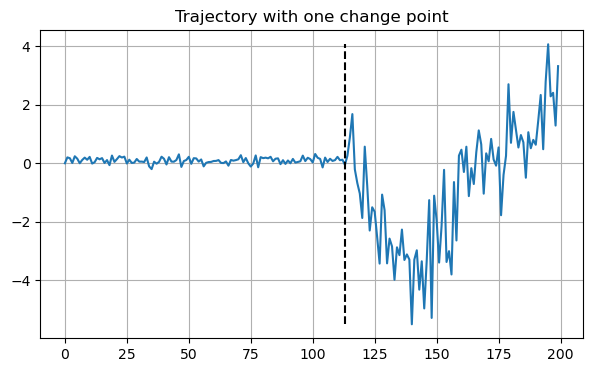

In [ ]:
#| code-fold: true
plt.figure(figsize=(7,4))
plt.plot(x0.x[0])
plt.vlines(x0.cp.item(), min(x0.x[0]), max(x0.x[0]), linestyles='dashed', colors='k')
plt.grid()
plt.title("Trajectory with one change point")
plt.xlabel("Time step")
plt.ylabel("Position");

## Brownian motion

We simulate Brownian motion taking the displacements as white noise with standard deviation $\sqrt{2D\delta t}$, where $D$ is the diffusion coefficient and $\delta t$ is the time-step duration (we generally take $\delta t=1$).

In [ ]:
#| export
def brownian_motion(n_traj, max_t, D, dim=1, dt=1):
    "Simulate Brownian motion trajectories."
    bm = (np.sqrt(2*D*dt)*np.random.randn(n_traj, dim, max_t)).cumsum(-1)
    return bm - bm[:, :, 0, None]

In [ ]:
#| export
@delegates(brownian_motion)
def create_bm_trajectories(n_traj, max_t, Ds=[1.], shuffle=True, **kwargs):
    "Simulate Brownian motion trajectories with various diffusion coefficients."
    if not isinstance(Ds, Iterable): Ds = [Ds]
    n_per_d = n_traj//len(Ds)
    Ds = np.repeat(np.array(Ds), n_per_d)
    bms = brownian_motion(len(Ds), max_t, Ds[:, None, None], **kwargs)
    info = np.tile(Ds, (2, 1)).T
    trajs = np.concatenate((info, bms.reshape(info.shape[0], -1)), -1)
    return np.random.permutation(trajs) if shuffle else trajs

Similar to `create_andi_trajectories`, `create_bm_trajectories` evenly distributes the amount of trajectories for each diffusion coefficient we consider.

In [ ]:
n_traj = 9
max_t = 5
trajectories = create_bm_trajectories(n_traj, max_t, dim=1, Ds=[1., 2.], shuffle=False)
trajectories.shape

(8, 7)

Despite only having one parameter: the diffusion coefficient $D$, we still find two additional terms in the trajectory length which are, simply, two copies of $D$. This is to keep a consistent formatting with the anomalous diffusion trajectories that need to store the model and $\alpha$.

In [ ]:
#| export
@delegates(combine_trajectories)
def create_bm_segmentation_dataset(
    n_traj:int,              # Number of trajectories
    max_t:int=200,           # Maximum trajectory length
    dim:int=1,               # Trajectory dimension
    n_change_points:int=1,   # Number of changepoints in the trajectories
    Ds:Iterable|None=None,   # Diffusion coefficients to consider defaults to logspace(-3, 3)
    path:Path|str|None=None, # Path to save the data
    save:bool=True,          # Save or not the data
    **kwargs
    )->pd.DataFrame:
    "Creates a segmentation dataset to tell between diffusion coefficients."
    n_ds = n_change_points + 1
    Ds = np.logspace(-3, 3, n_traj//100) if Ds is None else Ds
    datasets = [create_bm_trajectories(n_traj, max_t, Ds=Ds, dim=dim) for _ in range(n_ds)]
    trajectories, labels, change_points = combine_trajectories(datasets, dim, **kwargs)
    seg_dataset = trajs2df(trajectories, labels, change_points, dim)
    save_path = DATA_PATH/get_bmds_fname(n_change_points, max_t, dim) if path is None else path
    if save: seg_dataset.to_pickle(save_path)
    return seg_dataset

def get_bmds_fname(n_change_points, max_t, dim):
    "Returns consistent file name for segmentation dataset."
    return f"bmds_{n_change_points}changes_T{max_t}_dim{dim}.pkl"

The behaviour is very similar to `create_andi_segmentation_dataset`. Let's see an example.

In [ ]:
N = 100
df = create_bm_segmentation_dataset(N, Ds=[10, 50, 100], save=False)

In [ ]:
x0 = df.iloc[1]
x0.exps, x0.cp

(tensor([100.,  10.]), tensor([54]))

The trajectory changes from $D=100$ to $D=10$ at the 54th time-step.

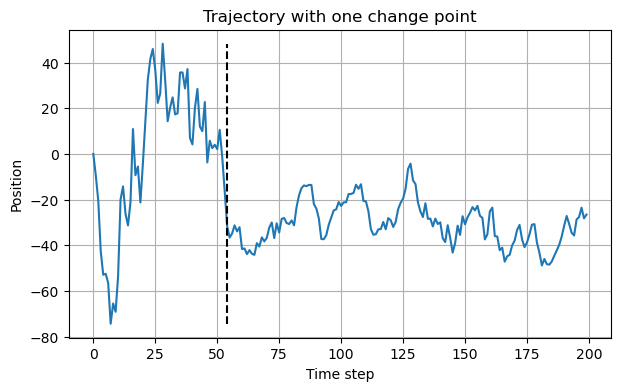

In [ ]:
#| code-fold: true
plt.figure(figsize=(7,4))
plt.plot(x0.x[0])
plt.vlines(x0.cp.item(), min(x0.x[0]), max(x0.x[0]), linestyles='dashed', colors='k')
plt.grid()
plt.title("Trajectory with one change point")
plt.xlabel("Time step")
plt.ylabel("Position");

### ATTM trajectories

Annealed transit time (ATTM) is an anomalous diffusion model consisting of piecewise normal diffusion. Every segment has a random diffusion coefficient $D$ drawn with probability 
$$P(D) = \frac{D^{\sigma - 1}\exp(-D/b)}{b^\sigma\Gamma(\sigma)}\,,$$
with parameters $\sigma$ and $b$. The residence time in each diffusive state, $\tau$, depends on the magnitude of the diffusion coefficient: $$P_\tau(\tau|D)=\frac{D^\gamma}{k}\exp(-\tau D^\gamma/k)\,,$$ with parameters $\gamma$ and $k$. The parameters $\sigma$ and $\gamma$ in these distributions determine the anomalous exponent $\alpha=\sigma/\gamma$, whenever $\sigma<\gamma<\sigma+1$. Thus, for every $\alpha$ there are infinitely many valid combinations of $\sigma, \,\gamma$. 

In [andi_datasets](https://github.com/AnDiChallenge/andi_datasets), these parameters are randomly sampled given a fixed $\alpha$. Here, we wish to extract $\sigma$ and $\gamma$ and, thus, we need a consistent way to simulate ATTM trajectories with those parameters fixed.

::: {.callout-note}
In [our work](https://arxiv.org/abs/2302.00410), we use ATTM trajectories to show how to characterize anomalous diffusion directly from changes in normal diffusion.
:::

In [ ]:
#| export
def create_fixed_attm_trajs(n_traj, max_t, sigma, gamma):
    "Creates 2-D ATTM trajectories with fixed sigma and gamma."
    trajs = np.zeros((n_traj, 2, max_t))
    Ds = np.zeros((n_traj, max_t))
    t0, t1 = np.ones(n_traj, dtype=int), np.zeros(n_traj, dtype=int)
    idx = np.arange(n_traj)
    while (t0 < max_t).any():
        not_done = t0 < max_t 
        D = (1 - np.random.uniform(low=0.1, high=0.99, size=not_done.sum()))**(1/sigma)
        t1[not_done] = t0[not_done] + (D**(-gamma)).astype(int)
        t1 = np.where((t1 > max_t) & not_done, max_t, t1)
        dt = t1 - t0
        for i, d in zip(idx[not_done], D):
            trajs[i, : , t0[i]:t1[i]] = (np.expand_dims(trajs[i, :, t0[i]-1], -1)
                                         + brownian_motion(1, dt[i]+1, d, dim=2)[0, :, 1:])
            Ds[i, t0[i]:t1[i]] = d
        t0 = np.copy(t1)
    Ds[:, 0] = Ds[:, 1]
    return trajs, Ds

Let's generate some ATTM trajectories with fixed $\sigma=0.3$ and $\gamma=0.4$, meaning that $\alpha=0.75$.

In [ ]:
#| hide
np.random.seed(7)

In [ ]:
n_traj = 2
max_t = 15
sigma, gamma = 0.3, 0.4
trajs, ds = create_fixed_attm_trajs(n_traj, max_t, sigma, gamma)

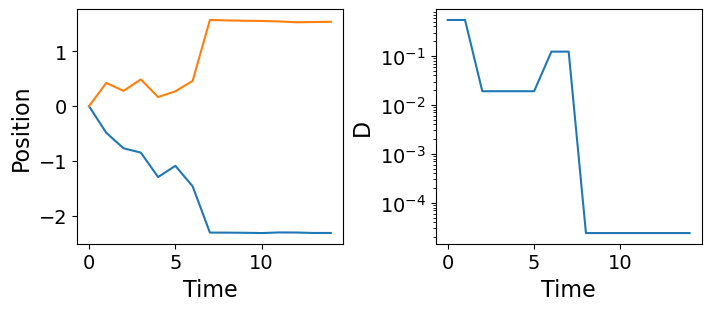

In [ ]:
#| code-fold: true
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), constrained_layout=True)
axes[0].plot(trajs[0].T)
axes[0].set_xlabel("Time", fontsize=16)
axes[0].set_ylabel("Position", fontsize=16)
axes[0].tick_params(labelsize=14)

axes[1].semilogy(ds[0])
axes[1].set_xlabel("Time", fontsize=16)
axes[1].set_ylabel("D", fontsize=16)
axes[1].tick_params(labelsize=14)

## Datasets with variable number of change points

So far we have shown how to build data sets with a fixed number of changepoints. In order to make a dataset that contains a variable number of change points, we can simply combine several of those in a smart way.

This will make our models much more robust and allow us to generalize better to experimental data with an arbitrary number of changes along the trajectories.

In [ ]:
#| export
def combine_datasets(datasets, shuffle=True):
    "Combines data sets together."
    dataset = pd.concat(datasets, ignore_index=True)
    if shuffle: dataset = dataset.sample(frac=1).reset_index(drop=True)
    return dataset

### Example: Brownian motion

With this code, we have generated the main test set of Brownian motion trajectories to validate our models.

In [ ]:
N_per_set = 12000
max_t = 200
dim = 2
Ds = np.logspace(-3, 3, 1000) 
cps = [1, 2, 3, 4]
# Choose a function to create datasets either brownian motion or anomalous diffusion
ds_fun = partial(create_bm_segmentation_dataset,
                 max_t=max_t, dim=dim, Ds=Ds, save=False)

In [ ]:
datasets = [ds_fun(N_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)

save_path = DATA_PATH/get_bmds_fname(f'{min(cps)}_to_{max(cps)}_test', max_t, dim)
dataset.to_pickle(save_path)

### Example: anomalous diffusion

With this code, we have generated the main test set of anomalous diffusion trajectories to validate our models.

In [ ]:
N_per_set = 12500
max_t = 200
dim = 2 
cps = [1, 2, 3, 4]
# Choose a function to create datasets either brownian motion or anomalous diffusion
ds_fun = partial(create_andi_segmentation_dataset,
                 models=models, max_t=max_t, dim=dim, noise=[0.], save=False)

In [ ]:
datasets = [ds_fun(N_per_set, n_change_points=n_cp) for n_cp in cps]
dataset = combine_datasets(datasets)

save_path = DATA_PATH/get_andids_fname(f'{min(cps)}_to_{max(cps)}_test', max_t, dim)
dataset.to_pickle(save_path)

# Validation with AnDi

It is useful to validate our models over the [AnDi challenge](http://andi-challenge.org/) data sets to compare them with the top performing models of the challenge.

By default, we asume the data is in `DATA_PATH/andi_val_{task_number}`.

In [ ]:
#| export
def load_andi_data(dim=1, task=1, path=None):
    "Loads data from AnDi."
    path = DATA_PATH/f'andi_val_{task}' if path is None else path
    try: 
        df = pd.read_pickle(path.with_suffix(".pkl"))
    except: 
        _txt2df(path)
        df = pd.read_pickle(path.with_suffix(".pkl"))    
    return df[df['dim']==dim].reset_index(drop=True)

def _txt2df(path):
    "Extracts dataset and saves it in a DataFrame."
    txt_path = path.with_suffix(".txt")
    toy_y = tensor([])
    data = []
    with open(txt_path, 'r') as f:
        trajs = csv.reader(f, delimiter=";", lineterminator="\n",
                           quoting=csv.QUOTE_NONNUMERIC)
        for t in trajs:
            dim, x = int(t[0]), tensor(t[1:])
            x = x.view(dim, -1)
            data.append({'dim': dim, 'len': x.shape[1], 'x': x, 'y': toy_y})
    df = pd.DataFrame.from_records(data)
    df.to_pickle(path.with_suffix(".pkl"))

In [ ]:
df = load_andi_data(dim=2)
df.shape

(10000, 4)

In [ ]:
df.head(2)

,dim,len,x,y
0,2,200,"[[tensor(0.), tensor(-0.5156), tensor(-0.8383), tensor(-1.4615), tensor(-1.7552), tensor(-1.6362), tensor(-1.4192), tensor(-1.3548), tensor(-1.2144), tensor(-1.7406), tensor(-1.6199), tensor(-1.4474), tensor(-0.2902), tensor(0.5447), tensor(0.5666), tensor(0.1618), tensor(-0.1004), tensor(-0.1377), tensor(-1.1998), tensor(-1.9200), tensor(-3.1992), tensor(-4.4678), tensor(-5.7045), tensor(-6.3007), tensor(-6.6895), tensor(-7.5415), tensor(-7.9907), tensor(-9.3120), tensor(-10.1935), tensor(-10.5246), tensor(-11.5122), tensor(-12.5124), tensor(-13.6076), tensor(-13.9701), tensor(-14.3846), ...",[]
1,2,200,"[[tensor(0.), tensor(1.8434), tensor(2.5901), tensor(3.3360), tensor(3.3675), tensor(5.1754), tensor(6.7046), tensor(6.5266), tensor(5.5823), tensor(4.2652), tensor(2.6675), tensor(2.0960), tensor(1.3606), tensor(-0.0349), tensor(-1.4965), tensor(-0.4068), tensor(-1.8796), tensor(-1.7324), tensor(-1.8430), tensor(-0.4918), tensor(0.8988), tensor(1.1704), tensor(2.8995), tensor(3.4126), tensor(3.3071), tensor(4.3777), tensor(4.9901), tensor(6.3406), tensor(7.1728), tensor(8.1412), tensor(9.1267), tensor(9.0713), tensor(9.1243), tensor(11.2437), tensor(12.1926), tensor(12.3969), tensor(12.98...",[]


# DataLoaders

Data loaders are essential to train our machine learning models. We provide functions that load the data and return appropiate `fastai.DataLoaders` for the segmentation tasks.

In [ ]:
#| export
def load_dataset(n_change=1, max_t=200, dim=1, path=None, bm=False):
    "Loads dataset according to `n_change`, `max_t` and `dim` or straight from `path`."
    name_fn = get_bmds_fname if bm else get_andids_fname
    load_path = DATA_PATH/name_fn(n_change, max_t, dim) if path is None else path
    return pd.read_pickle(load_path)

In [ ]:
#| export
@delegates(load_dataset)
def get_segmentation_dls(
    target:str='y_mod',       # Task target `y_mod`, `y_exp` or `y` for both. 
    models:list|None=None,    # List of models to consider. Defaults to all.
    exps:Iterable|None=None,  # List of anomalous exponents to consider. Deafults to all.
    size:int|None=None,       # Maximum data set size. Defaults to full data set.
    bs:int=128,               # Batch size.
    split_pct:float=0.2,      # Validation set split percentage from training data.
    shuffle:bool=True,        # Shuffle the dataset.
    tfm_y:Callable|None=None, # Transformation to apply to the target, e.g., `torch.log10`.
    n_change:int|str=1,       # Number of changes in the trajectories, e.g., '1_to_4'.
    **kwargs
    )->DataLoaders:
    "Obtain `DataLoaders` from dataset filtered by `models` and `exps` to predict `target`."
    ds = load_dataset(**kwargs)
    if models is not None or exps is not None: ds = _filter_dataset(ds, models, exps, n_change)
    if size is not None and size <= ds.shape[0]: ds = _subsample_dataset(ds, size)
    x = ds['x'].map(partial(torch.transpose, dim0=1, dim1=0))
    y = ds[target].map(torch.squeeze)
    if tfm_y is not None: y = y.map(tfm_y)
    ds = L(zip(x, y))
    return _get_dls_from_ds(ds, split_pct=split_pct, bs=bs, shuffle=shuffle)

def _filter_dataset(dataset, models=None, exps=None, n_change=1):
    "Returns dataset filtered by `models` and `exps`."
    if models is not None: dataset = dataset[_check_in(dataset.models, models, n_change)]
    if exps is not None:   dataset = dataset[_check_in(dataset.exps, exps, n_change)]
    return dataset

def _check_in(series, objects, n_change):
    "Checks whether objects are in elements of a given `pandas.Series`."
    return sum([series.apply(lambda x: o in x) for o in objects]) > n_change

def _subsample_dataset(dataset, n_max):
    "Takes `n_max` samples from `dataset` in `pandas.DataFrame` format."
    return dataset.sample(n_max).reset_index(drop=True)

def _get_dls_from_ds(ds, split_pct=0.2, bs=128, shuffle=True):
    "Returns `DataLoaders` built from `ds`."
    idx = torch.randperm(len(ds)) if shuffle else tensor(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_ds, val_ds = ds[idx[cut:]], ds[idx[:cut]]
    return DataLoaders.from_dsets(train_ds, val_ds, bs=bs, shuffle=shuffle)

This is the main function to obtain `DataLoaders` for a segmentation task. These provide the trajetories with their corresponding labels at every time step.

Let's see an example for a classification task (setting `target='y_mod'`). We take a sub-sample of the dataset of `size=100` with a batch size `bs=4`.

In [ ]:
seg_dls = get_segmentation_dls(size=100, bs=4)
x, y = seg_dls.one_batch()
x.shape, y.shape

(torch.Size([4, 200, 1]), torch.Size([4, 200]))

In this example, we have 1-dimensional trajectories with 200 time steps. Thus, the target is also 200 frames long. 

In [ ]:
x[0, :5], y[0, :5]

(tensor([[0.0000],
         [3.3110],
         [4.2102],
         [7.4056],
         [4.6176]]),
 tensor([3, 3, 3, 3, 3]))

In [ ]:
#| export
@delegates(TfmdLists.dataloaders)
def get_transformer_dls(target='y_mod', dim=1, n_change=1, max_t=200, valid_pct=0.2, models=None,
                        exps=None, size=None, data_path=None, init_token=None, **kwargs):
    "Obtain `DataLoaders` from filtered dataset prepared for transformer training."
    ds = load_dataset(n_change=n_change, max_t=max_t, dim=dim, path=data_path)
    if models is not None or exps is not None: ds = _filter_dataset(ds, models, exps, n_change)
    if size is not None and size <= ds.shape[0]: ds = _subsample_dataset(ds, size)
    n_class = _get_n_class(target, ds)
    splits = RandomSplitter(valid_pct=valid_pct)(list(ds.index))
    tfm = SegmentationTransform(target=target, n_class=n_class, init_token=init_token)
    tfl = TfmdLists(ds, tfm, splits=splits)
    return tfl.dataloaders(**kwargs)

class SegmentationTransform(Transform):
    def __init__(self, target='y_mod', n_class=5, init_token=None):
        "Transform to process rows from dataset in `pandas.DataFrame` format."
        store_attr('target,n_class,init_token')
        self.one_hot_encode = target == 'y' or target == 'y_mod'
        
    def encodes(self, row):
        x, y = self._get_xy(row)
        y_one_hot = _one_hot_encode(y, self.n_class) if self.one_hot_encode else deepcopy(y)
        y_one_hot = _prepend_initial_token(y_one_hot, self.init_token)
        return (x, y_one_hot.squeeze(), y.squeeze())
        
    def _get_xy(self, row):
        return row['x'].transpose(1,0), row[self.target].transpose(1,0)

def _one_hot_encode(sample, n_class=5):
    "One-hot encodes the labels in sample."
    idx = sample[:, 0].long().unsqueeze(-1)
    one_hot_sample = torch.zeros(idx.shape[0], n_class)
    one_hot_sample.scatter_(-1, idx, 1)
    if sample.shape[1] == 2: one_hot_sample[:, -1] = deepcopy(sample[:, -1])
    return one_hot_sample

def _prepend_initial_token(sample, token=None):
    "Prepends an initial token into the sample trajectory dropping the last point."
    if token is None: token = DEFAULT_TOKEN * torch.ones([1, sample.shape[1]])
    return torch.cat([token, sample[:-1]], dim=0)

def _get_n_class(task, df):
    "Figures the output size for the `task` (prediction target) given the dataset `df`."
    if task == 'y_exp': return 1
    else: 
        n_class = len(torch.cat(tuple(df['models'])).unique())
        if task == 'y': n_class += 1
    return n_class

Transformer data loaders provide three items: raw trajectory (src), one-hot encoding of labels (tgt) and the labels to compute the loss. These are mainly intended for pointwise classification tasks, such as inferring the anomalous diffusion model behind the simulation. Otherwise, the one-hot-encoding does not make much sense.

In [ ]:
tfm_dls = get_transformer_dls(size=100, bs=4)

In [ ]:
x, y_one_hot, y = tfm_dls.one_batch()
x.shape, y_one_hot.shape, y.shape

(torch.Size([4, 200, 1]), torch.Size([4, 200, 5]), torch.Size([4, 200]))

In [ ]:
idx = 0
x[idx, :5], y_one_hot[idx, :5], y[idx, :5]

(tensor([[ 0.0000],
         [-0.0976],
         [-0.0456],
         [ 0.0426],
         [ 0.0395]], device='cuda:0'),
 tensor([[-1., -1., -1., -1., -1.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.]], device='cuda:0'),
 tensor([2, 2, 2, 2, 2], device='cuda:0'))

In [ ]:
#| export
@delegates(load_andi_data)
def get_andi_valid_dls(bs=128, pct=1, **kwargs):
    "Obtain `DataLoaders` from AnDi challenge validation data."
    ds = load_andi_data(**kwargs)
    x = ds['x'].map(partial(torch.transpose, dim0=1, dim1=0))
    y = ds['y']
    ds = L(zip(x, y))
    return _get_dls_from_ds(ds, split_pct=pct, bs=bs, shuffle=False)

When validating on the [AnDi challenge](http://andi-challenge.org/) data, in some cases, it may be convenient to work with `DataLoaders` instaed of `DataFrames`, which can be obtained through `load_andi_data`. These are mainly intended to test our models. Thus, notice that the split percentage for train/validation is set to 100% validation by default. 

In [ ]:
andi_dls = get_andi_valid_dls(dim=2)
x, y = andi_dls.valid.one_batch()
x.shape, y.shape

(torch.Size([128, 200, 2]), torch.Size([128, 0]))

In [ ]:
x[0, :5]

tensor([[ 0.0000,  0.0000],
        [-0.5156,  0.5875],
        [-0.8383,  0.5096],
        [-1.4615,  0.5320],
        [-1.7552,  0.4109]])